Let's clean our data

In [121]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('data/train.csv')

# Separate features and target
X = df.drop('SalePrice', axis=1)  # assuming 'SalePrice' is your target
y = df['SalePrice']

def encode_categorical_features(X):
    """
    Encodes categorical features in the DataFrame X using OneHotEncoder.
    Returns a DataFrame with encoded features.
    """
    # Get categorical columns from features only
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Handle missing values first
    X_clean = X.copy()
    # for col in categorical_cols:
    #     X_clean[col] = X_clean[col].fillna('Missing')

    # Fill numeric missing values
    numeric_cols = X_clean.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        X_clean[col] = X_clean[col].fillna(X_clean[col].median())

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ],
        remainder='passthrough'  # keep other (non-categorical) columns
    )

    transformed = preprocessor.fit_transform(X_clean)
    feature_names = preprocessor.get_feature_names_out()
    return pd.DataFrame(transformed, columns=feature_names) # type: ignore

final_df = encode_categorical_features(X)



Let's use a baseline model first:

In [122]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
# Use all your training data for CV
cv_scores = cross_val_score(lr_model, final_df, y, cv=5, scoring='neg_mean_squared_error')



def print_scores(scores):
    rmse = np.sqrt(-scores)
    # Calculate percentage error
    mean_target = y.mean()
    rmse_mean = rmse.mean()
    rmse_std = rmse.std()

    # Calculate percentage error
    percentage_error = (rmse_mean / mean_target) * 100
    percentage_error_std = (rmse_std * 2 / mean_target) * 100

    print(f"Model Performance (CV): ${rmse_mean:,.2f} (+/- ${rmse_std * 2:,.2f})")
    print(f"Percentage Error (CV): {percentage_error:.2f}% (+/- {percentage_error_std:.2f}%)")
    print(f"Target variable mean: ${mean_target:,.2f}")
    
print_scores(cv_scores)


Model Performance (CV): $35,433.85 (+/- $16,530.80)
Percentage Error (CV): 19.59% (+/- 9.14%)
Target variable mean: $180,921.20


Now that we have a baseline let's try more models and choose one that performs best

In [123]:
# Random forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_cv_scores = cross_val_score(rf_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(rf_cv_scores)

Model Performance (CV): $30,095.84 (+/- $7,696.55)
Percentage Error (CV): 16.63% (+/- 4.25%)
Target variable mean: $180,921.20


In [124]:
# XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1)

xgb_cv_scores = cross_val_score(xgb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(xgb_cv_scores)


Model Performance (CV): $27,268.95 (+/- $8,965.59)
Percentage Error (CV): 15.07% (+/- 4.96%)
Target variable mean: $180,921.20


In [125]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)

gb_cv_scores = cross_val_score(gb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(gb_cv_scores)


Model Performance (CV): $26,219.22 (+/- $6,816.72)
Percentage Error (CV): 14.49% (+/- 3.77%)
Target variable mean: $180,921.20


In [126]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, learning_rate=0.1, verbose=-1)

lgb_cv_scores = cross_val_score(lgb_model, final_df, y, cv=5, scoring='neg_mean_squared_error') # type: ignore

print_scores(lgb_cv_scores)

Model Performance (CV): $28,685.10 (+/- $8,337.02)
Percentage Error (CV): 15.86% (+/- 4.61%)
Target variable mean: $180,921.20


In [127]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# SVR works better with scaled features
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=100, gamma='scale'))
])

svr_cv_scores = cross_val_score(svr_pipeline, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(svr_cv_scores)

Model Performance (CV): $79,331.77 (+/- $12,720.58)
Percentage Error (CV): 43.85% (+/- 7.03%)
Target variable mean: $180,921.20


From all our models GradientBoosting gives the best results. Let's do feature engineering now to improve our results

In [128]:
# Let's remove Id
from sklearn.ensemble import GradientBoostingRegressor

X_clean = X.copy()
X_clean = X_clean.drop(columns=["Id"]) # remove numerical features with 0.03 < correlation > -0.03. Removing more gives worse results

final_df = encode_categorical_features(X_clean)

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)

gb_cv_scores = cross_val_score(gb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(gb_cv_scores)

Model Performance (CV): $26,702.86 (+/- $7,965.73)
Percentage Error (CV): 14.76% (+/- 4.40%)
Target variable mean: $180,921.20


In [129]:
# Let's remove features with very weak correlation (close to zero)
from sklearn.ensemble import GradientBoostingRegressor

X_clean = X.copy()
X_clean = X_clean.drop(columns=['BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', "Id"]) # remove numerical features with 0.03 < correlation > -0.03. Removing more gives worse results

final_df = encode_categorical_features(X_clean)

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)

gb_cv_scores = cross_val_score(gb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(gb_cv_scores)

Model Performance (CV): $26,289.06 (+/- $7,933.59)
Percentage Error (CV): 14.53% (+/- 4.39%)
Target variable mean: $180,921.20


In [130]:
# Let's remove features with very weak correlation (close to zero)
from sklearn.ensemble import GradientBoostingRegressor

X_clean = X.copy()
X_clean = X_clean.drop(columns=['BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', "Id", 'LowQualFinSF', 'YrSold']) # remove numerical features with 0.03 < correlation > -0.03. Removing more gives worse results

final_df = encode_categorical_features(X_clean)

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)

gb_cv_scores = cross_val_score(gb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(gb_cv_scores)

Model Performance (CV): $26,589.31 (+/- $6,461.66)
Percentage Error (CV): 14.70% (+/- 3.57%)
Target variable mean: $180,921.20


In [131]:
# Let's try to remove weak categorical features

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor

# Method 4: Tree-based Feature Importance
def get_low_importance_categorical(X, y, importance_threshold=0.001):
    """
    Use Random Forest to identify categorical features with low importance
    """
    # Encode categorical features temporarily
    temp_df = encode_categorical_features(X)
    
    # Fit Random Forest to get feature importances
    rf_temp = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_temp.fit(temp_df, y)
    
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': temp_df.columns,
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Identify original categorical column names from encoded features
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    categorical_importance = {}
    
    for cat_col in categorical_cols:
        # Find all encoded features that belong to this categorical column
        encoded_features = [f for f in temp_df.columns if f.startswith(f'cat__{cat_col}')]
        # Sum importances of all encoded features for this categorical column
        total_importance = feature_importance[feature_importance['feature'].isin(encoded_features)]['importance'].sum()
        categorical_importance[cat_col] = total_importance
    
    # Identify low importance categorical features
    low_importance_features = [col for col, imp in categorical_importance.items() 
                              if imp < importance_threshold]
    
    return low_importance_features, categorical_importance

# Apply Method 4: Tree-based Feature Importance
print("\n=== Method 4: Tree-based Feature Importance ===")
low_importance_features, cat_importance = get_low_importance_categorical(X_clean, y)

print("Categorical feature importances:")
sorted_importance = sorted(cat_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

print(f"\nLow importance features: {low_importance_features}")


X_clean_clean = X.copy()
X_clean_clean.drop(columns=low_importance_features, inplace=True)

final_df_clean = encode_categorical_features(X_clean_clean)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
gb_cv_scores_clean = cross_val_score(gb_model, final_df_clean, y, cv=5, scoring='neg_mean_squared_error')
print_scores(gb_cv_scores_clean)




=== Method 4: Tree-based Feature Importance ===
Categorical feature importances:
BsmtQual: 0.0054
Neighborhood: 0.0049
GarageType: 0.0039
KitchenQual: 0.0039
ExterQual: 0.0034
BsmtExposure: 0.0025
Exterior1st: 0.0023
GarageFinish: 0.0022
CentralAir: 0.0022
FireplaceQu: 0.0021
Exterior2nd: 0.0021
MSZoning: 0.0019
LandContour: 0.0016
MasVnrType: 0.0016
LotShape: 0.0015
BsmtFinType1: 0.0013
SaleCondition: 0.0012
SaleType: 0.0012
LotConfig: 0.0011
Condition1: 0.0011
HouseStyle: 0.0010
RoofStyle: 0.0010
GarageQual: 0.0009
Heating: 0.0008
Foundation: 0.0008
ExterCond: 0.0008
BsmtFinType2: 0.0007
HeatingQC: 0.0007
GarageCond: 0.0007
Functional: 0.0005
BldgType: 0.0005
Fence: 0.0005
RoofMatl: 0.0005
LandSlope: 0.0004
BsmtCond: 0.0004
PavedDrive: 0.0004
Alley: 0.0003
Condition2: 0.0002
Electrical: 0.0002
PoolQC: 0.0001
MiscFeature: 0.0001
Street: 0.0000
Utilities: 0.0000

Low importance features: ['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',

Removing these features worsen our score. Let's remove only the limited ['BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', "Id", 'LowQualFinSF', 'YrSold'] that give us a base score of 14.70% (+/- 3.57%)

In [132]:
# Let's feature engineer new columns

X_new_features = X.copy()

# Aggregate Features

# Total bathrooms
X_new_features['TotalBath'] = X_new_features['FullBath'] + X_new_features['HalfBath'] * 0.5 + X_new_features['BsmtFullBath'] + X_new_features['BsmtHalfBath'] * 0.5

# Total porch area
X_new_features['TotalPorchSF'] = X_new_features['OpenPorchSF'] + X_new_features['EnclosedPorch'] + X_new_features['3SsnPorch'] + X_new_features['ScreenPorch']

# Living area per room
X_new_features['LivAreaPerRoom'] = X_new_features['GrLivArea'] / X_new_features['TotRmsAbvGrd']

# Age-Based Features

# House age at time of sale
X_new_features['HouseAge'] = X_new_features['YrSold'] - X_new_features['YearBuilt']

# Years since remodel
X_new_features['YearsSinceRemodel'] = X_new_features['YrSold'] - X_new_features['YearRemodAdd']

# Garage age
X_new_features['GarageAge'] = X_new_features['YrSold'] - X_new_features['GarageYrBlt']

# Was house remodeled?
X_new_features['IsRemodeled'] = (X_new_features['YearRemodAdd'] != X_new_features['YearBuilt']).astype(int)


# Quality/Condition Combinations

# Overall quality * condition interaction
X_new_features['QualCondProduct'] = X_new_features['OverallQual'] * X_new_features['OverallCond']

# Quality scores (convert categorical to numerical)
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
X_new_features['ExterQual_num'] = X_new_features['ExterQual'].map(quality_map)
X_new_features['KitchenQual_num'] = X_new_features['KitchenQual'].map(quality_map)

# Average quality score
X_new_features['AvgQuality'] = (X_new_features['OverallQual'] + X_new_features['ExterQual_num'] + X_new_features['KitchenQual_num']) / 3


# Has specific features
X_new_features['HasPool'] = (X_new_features['PoolArea'] > 0).astype(int)
X_new_features['HasGarage'] = (X_new_features['GarageArea'] > 0).astype(int)
X_new_features['HasBasement'] = (X_new_features['TotalBsmtSF'] > 0).astype(int)
X_new_features['HasFireplace'] = (X_new_features['Fireplaces'] > 0).astype(int)
X_new_features['HasWoodDeck'] = (X_new_features['WoodDeckSF'] > 0).astype(int)
X_new_features['HasFence'] = (X_new_features['Fence'] != 'NA').astype(int)


# Garage to lot area ratio
X_new_features['GarageRatio'] = X_new_features['GarageArea'] / X_new_features['LotArea']

# Living area to lot area ratio
X_new_features['LivAreaRatio'] = X_new_features['GrLivArea'] / X_new_features['LotArea']


# Is corner lot
X_new_features['IsCornerLot'] = (X_new_features['LotConfig'] == 'Corner').astype(int)

# Sale season
X_new_features['SaleSeason'] = X_new_features['MoSold'].apply(lambda x: 'Spring' if x in [3,4,5] 
                                      else 'Summer' if x in [6,7,8]
                                      else 'Fall' if x in [9,10,11] 
                                      else 'Winter')

# House size categories
X_new_features['HouseSizeCategory'] = pd.cut(X_new_features['GrLivArea'], 
                                bins=[0, 1200, 1800, 2500, float('inf')], 
                                labels=['Small', 'Medium', 'Large', 'XLarge'])


# Create indicators for missing values in key features
missing_features = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
for feature in missing_features:
    X_new_features[f'{feature}_Missing'] = X_new_features[feature].isnull().astype(int)
    



In [133]:
# Let's compare all models again with the new features

print("=== Random Forest with New Features ===")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(rf_cv_scores)

print("=== XGBoost with New Features ===")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
xgb_cv_scores = cross_val_score(xgb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(xgb_cv_scores)

print("=== LightGBM with New Features ===")
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, learning_rate=0.1, verbose=-1)
lgb_cv_scores = cross_val_score(lgb_model, final_df, y, cv=5, scoring='neg_mean_squared_error') # type: ignore
print_scores(lgb_cv_scores)


print("=== Gradient Boosting with New Features ===")
final_df = encode_categorical_features(X_new_features)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
gb_cv_scores_clean = cross_val_score(gb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print_scores(gb_cv_scores_clean)








=== Random Forest with New Features ===
Model Performance (CV): $29,852.58 (+/- $7,576.43)
Percentage Error (CV): 16.50% (+/- 4.19%)
Target variable mean: $180,921.20
=== XGBoost with New Features ===
Model Performance (CV): $27,712.17 (+/- $9,298.73)
Percentage Error (CV): 15.32% (+/- 5.14%)
Target variable mean: $180,921.20
=== LightGBM with New Features ===
Model Performance (CV): $28,730.80 (+/- $8,638.87)
Percentage Error (CV): 15.88% (+/- 4.77%)
Target variable mean: $180,921.20
=== Gradient Boosting with New Features ===
Model Performance (CV): $25,893.63 (+/- $6,970.47)
Percentage Error (CV): 14.31% (+/- 3.85%)
Target variable mean: $180,921.20


in our test Gradient Boosting is still the best. 

Let's optimize the hyperparameters with Optuna

[I 2025-07-02 19:18:28,965] A new study created in memory with name: no-name-7643f9b5-1ff6-4f49-9975-4e2c26395264


Starting hyperparameter optimization with Optuna...


Best trial: 0. Best value: 26699.3:   1%|          | 1/100 [00:01<02:21,  1.43s/it]

[I 2025-07-02 19:18:30,396] Trial 0 finished with value: 26699.311138751924 and parameters: {'n_estimators': 380, 'learning_rate': 0.0583831709389181, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 2, 'subsample': 0.6098208995546849, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   2%|▏         | 2/100 [00:32<31:10, 19.09s/it]

[I 2025-07-02 19:19:01,850] Trial 1 finished with value: 31972.421485783023 and parameters: {'n_estimators': 381, 'learning_rate': 0.28035039571926346, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 7, 'subsample': 0.6272577447464435, 'max_features': None}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   3%|▎         | 3/100 [00:34<17:37, 10.90s/it]

[I 2025-07-02 19:19:03,009] Trial 2 finished with value: 27453.132978285794 and parameters: {'n_estimators': 259, 'learning_rate': 0.07727111307946756, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.6258056895825993, 'max_features': 'sqrt'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   4%|▍         | 4/100 [01:19<39:27, 24.66s/it]

[I 2025-07-02 19:19:48,760] Trial 3 finished with value: 29821.114151518075 and parameters: {'n_estimators': 419, 'learning_rate': 0.27322172022818975, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 9, 'subsample': 0.9402442819683159, 'max_features': None}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   5%|▌         | 5/100 [01:50<42:44, 26.99s/it]

[I 2025-07-02 19:20:19,892] Trial 4 finished with value: 28198.934990447404 and parameters: {'n_estimators': 433, 'learning_rate': 0.01593396594864841, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 10, 'subsample': 0.8802187872166627, 'max_features': None}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   6%|▌         | 6/100 [01:51<28:21, 18.10s/it]

[I 2025-07-02 19:20:20,731] Trial 5 finished with value: 28257.504914202324 and parameters: {'n_estimators': 225, 'learning_rate': 0.03478117345491611, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 9, 'subsample': 0.9053504220003571, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   7%|▋         | 7/100 [01:53<19:36, 12.65s/it]

[I 2025-07-02 19:20:22,146] Trial 6 finished with value: 30204.119790658242 and parameters: {'n_estimators': 193, 'learning_rate': 0.014341075809094044, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 9, 'subsample': 0.9375327458706648, 'max_features': 'sqrt'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   8%|▊         | 8/100 [02:00<16:33, 10.80s/it]

[I 2025-07-02 19:20:28,987] Trial 7 finished with value: 30410.528486061237 and parameters: {'n_estimators': 73, 'learning_rate': 0.07767310963432358, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.8942643653420812, 'max_features': None}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:   9%|▉         | 9/100 [02:00<11:32,  7.61s/it]

[I 2025-07-02 19:20:29,593] Trial 8 finished with value: 28758.288350434425 and parameters: {'n_estimators': 258, 'learning_rate': 0.16833816858383013, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7730283001472503, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:  10%|█         | 10/100 [02:02<08:44,  5.83s/it]

[I 2025-07-02 19:20:31,439] Trial 9 finished with value: 27976.96304674635 and parameters: {'n_estimators': 275, 'learning_rate': 0.10548190614659922, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.9580748298256804, 'max_features': 'sqrt'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:  11%|█         | 11/100 [02:03<06:39,  4.49s/it]

[I 2025-07-02 19:20:32,882] Trial 10 finished with value: 27158.42368008308 and parameters: {'n_estimators': 492, 'learning_rate': 0.03633198320675753, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.7268494245314757, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:  12%|█▏        | 12/100 [02:04<05:01,  3.42s/it]

[I 2025-07-02 19:20:33,863] Trial 11 finished with value: 26743.561520914554 and parameters: {'n_estimators': 487, 'learning_rate': 0.03819355257052508, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.7223790571990483, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:  13%|█▎        | 13/100 [02:05<03:46,  2.60s/it]

[I 2025-07-02 19:20:34,572] Trial 12 finished with value: 28105.766309235285 and parameters: {'n_estimators': 348, 'learning_rate': 0.03241634137240143, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6979202898456482, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:  14%|█▍        | 14/100 [02:06<03:05,  2.16s/it]

[I 2025-07-02 19:20:35,702] Trial 13 finished with value: 26945.16343029732 and parameters: {'n_estimators': 490, 'learning_rate': 0.04645100058947346, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 2, 'subsample': 0.6833560685735777, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 0. Best value: 26699.3:  15%|█▌        | 15/100 [02:07<02:34,  1.81s/it]

[I 2025-07-02 19:20:36,718] Trial 14 finished with value: 27679.151520857595 and parameters: {'n_estimators': 350, 'learning_rate': 0.02334417755016368, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 4, 'subsample': 0.8147815274210082, 'max_features': 'log2'}. Best is trial 0 with value: 26699.311138751924.


Best trial: 15. Best value: 26658.6:  16%|█▌        | 16/100 [02:09<02:21,  1.69s/it]

[I 2025-07-02 19:20:38,114] Trial 15 finished with value: 26658.593572774025 and parameters: {'n_estimators': 433, 'learning_rate': 0.06546574790062504, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.6177816358158115, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  17%|█▋        | 17/100 [02:10<02:03,  1.49s/it]

[I 2025-07-02 19:20:39,143] Trial 16 finished with value: 27775.211037848396 and parameters: {'n_estimators': 328, 'learning_rate': 0.06900648190662488, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6042398841435332, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  18%|█▊        | 18/100 [02:11<01:59,  1.46s/it]

[I 2025-07-02 19:20:40,544] Trial 17 finished with value: 29285.023333870347 and parameters: {'n_estimators': 425, 'learning_rate': 0.1305848844819065, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.6583748329144916, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  19%|█▉        | 19/100 [02:12<01:40,  1.24s/it]

[I 2025-07-02 19:20:41,273] Trial 18 finished with value: 27955.2437871568 and parameters: {'n_estimators': 134, 'learning_rate': 0.058392154320520896, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.8012061251395479, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  20%|██        | 20/100 [02:13<01:47,  1.34s/it]

[I 2025-07-02 19:20:42,857] Trial 19 finished with value: 27993.504787516682 and parameters: {'n_estimators': 314, 'learning_rate': 0.10632920461544484, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.6568482902662307, 'max_features': 'sqrt'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  21%|██        | 21/100 [02:15<01:51,  1.41s/it]

[I 2025-07-02 19:20:44,408] Trial 20 finished with value: 28274.456944043854 and parameters: {'n_estimators': 391, 'learning_rate': 0.010584838912706972, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.7446161697518625, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  22%|██▏       | 22/100 [02:16<01:44,  1.33s/it]

[I 2025-07-02 19:20:45,572] Trial 21 finished with value: 27101.5430788689 and parameters: {'n_estimators': 456, 'learning_rate': 0.04709589271545097, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.60111066011955, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  23%|██▎       | 23/100 [02:18<01:44,  1.36s/it]

[I 2025-07-02 19:20:46,991] Trial 22 finished with value: 27290.21889008271 and parameters: {'n_estimators': 473, 'learning_rate': 0.02498337667624125, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 2, 'subsample': 0.7033888264148154, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  24%|██▍       | 24/100 [02:19<01:36,  1.27s/it]

[I 2025-07-02 19:20:48,047] Trial 23 finished with value: 27125.35230442779 and parameters: {'n_estimators': 391, 'learning_rate': 0.04832784982743147, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.6553778193695701, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  25%|██▌       | 25/100 [02:20<01:43,  1.38s/it]

[I 2025-07-02 19:20:49,676] Trial 24 finished with value: 27486.030081237957 and parameters: {'n_estimators': 453, 'learning_rate': 0.02692140698463, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 4, 'subsample': 0.752670096040297, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  26%|██▌       | 26/100 [02:22<01:42,  1.39s/it]

[I 2025-07-02 19:20:51,086] Trial 25 finished with value: 27509.19591214045 and parameters: {'n_estimators': 400, 'learning_rate': 0.06331195898668339, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.8396123458304732, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  27%|██▋       | 27/100 [02:23<01:37,  1.34s/it]

[I 2025-07-02 19:20:52,310] Trial 26 finished with value: 27315.49046417956 and parameters: {'n_estimators': 466, 'learning_rate': 0.11062933566024813, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.9952847751146802, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  28%|██▊       | 28/100 [02:24<01:37,  1.36s/it]

[I 2025-07-02 19:20:53,722] Trial 27 finished with value: 29911.863630266216 and parameters: {'n_estimators': 500, 'learning_rate': 0.17779506947203746, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 7, 'subsample': 0.6749409632727632, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  29%|██▉       | 29/100 [02:49<09:56,  8.41s/it]

[I 2025-07-02 19:21:18,576] Trial 28 finished with value: 27577.786679062552 and parameters: {'n_estimators': 358, 'learning_rate': 0.019100644008289085, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 1, 'subsample': 0.6293350434768248, 'max_features': None}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  30%|███       | 30/100 [02:51<07:24,  6.35s/it]

[I 2025-07-02 19:21:20,107] Trial 29 finished with value: 27873.274134156603 and parameters: {'n_estimators': 298, 'learning_rate': 0.04098195758917357, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 6, 'subsample': 0.6358955170259297, 'max_features': 'sqrt'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  31%|███       | 31/100 [03:15<13:21, 11.62s/it]

[I 2025-07-02 19:21:44,032] Trial 30 finished with value: 27806.983622890566 and parameters: {'n_estimators': 371, 'learning_rate': 0.08282343869804634, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.7223488691146774, 'max_features': None}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  32%|███▏      | 32/100 [03:15<09:31,  8.40s/it]

[I 2025-07-02 19:21:44,918] Trial 31 finished with value: 26923.401991341012 and parameters: {'n_estimators': 438, 'learning_rate': 0.0467055601116038, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 2, 'subsample': 0.6837808438642958, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  33%|███▎      | 33/100 [03:16<06:50,  6.13s/it]

[I 2025-07-02 19:21:45,754] Trial 32 finished with value: 26828.396345006695 and parameters: {'n_estimators': 432, 'learning_rate': 0.055115058451615566, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 2, 'subsample': 0.6271330215303239, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  34%|███▍      | 34/100 [03:17<05:01,  4.56s/it]

[I 2025-07-02 19:21:46,662] Trial 33 finished with value: 26969.264953280835 and parameters: {'n_estimators': 410, 'learning_rate': 0.05853877288061091, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 3, 'subsample': 0.61933590337238, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  35%|███▌      | 35/100 [03:18<03:47,  3.49s/it]

[I 2025-07-02 19:21:47,660] Trial 34 finished with value: 27381.91885701696 and parameters: {'n_estimators': 425, 'learning_rate': 0.07227827942883908, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 1, 'subsample': 0.6430578664291986, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 15. Best value: 26658.6:  36%|███▌      | 36/100 [03:19<02:58,  2.79s/it]

[I 2025-07-02 19:21:48,809] Trial 35 finished with value: 27437.303153350436 and parameters: {'n_estimators': 474, 'learning_rate': 0.09004100050980328, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 3, 'subsample': 0.6238240494446446, 'max_features': 'log2'}. Best is trial 15 with value: 26658.593572774025.


Best trial: 36. Best value: 26064.3:  37%|███▋      | 37/100 [03:37<07:41,  7.32s/it]

[I 2025-07-02 19:22:06,707] Trial 36 finished with value: 26064.30759563947 and parameters: {'n_estimators': 447, 'learning_rate': 0.030623079269053673, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 2, 'subsample': 0.6008394049629439, 'max_features': None}. Best is trial 36 with value: 26064.30759563947.


Best trial: 36. Best value: 26064.3:  38%|███▊      | 38/100 [03:55<10:46, 10.42s/it]

[I 2025-07-02 19:22:24,359] Trial 37 finished with value: 28685.763643657603 and parameters: {'n_estimators': 381, 'learning_rate': 0.029819006226162417, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 8, 'subsample': 0.6000152407832339, 'max_features': None}. Best is trial 36 with value: 26064.30759563947.


Best trial: 36. Best value: 26064.3:  39%|███▉      | 39/100 [04:32<18:50, 18.53s/it]

[I 2025-07-02 19:23:01,815] Trial 38 finished with value: 26939.76583902047 and parameters: {'n_estimators': 447, 'learning_rate': 0.02016201265912428, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 3, 'subsample': 0.8531332084595407, 'max_features': None}. Best is trial 36 with value: 26064.30759563947.


Best trial: 36. Best value: 26064.3:  40%|████      | 40/100 [04:50<18:17, 18.29s/it]

[I 2025-07-02 19:23:19,533] Trial 39 finished with value: 28087.931136307405 and parameters: {'n_estimators': 402, 'learning_rate': 0.03663262537682093, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 10, 'subsample': 0.6717292522703887, 'max_features': None}. Best is trial 36 with value: 26064.30759563947.


Best trial: 36. Best value: 26064.3:  41%|████      | 41/100 [05:00<15:29, 15.75s/it]

[I 2025-07-02 19:23:29,377] Trial 40 finished with value: 28546.791984505027 and parameters: {'n_estimators': 233, 'learning_rate': 0.2951441955706219, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.7765625100328479, 'max_features': None}. Best is trial 36 with value: 26064.30759563947.


Best trial: 36. Best value: 26064.3:  42%|████▏     | 42/100 [05:01<11:00, 11.40s/it]

[I 2025-07-02 19:23:30,601] Trial 41 finished with value: 27523.963697990253 and parameters: {'n_estimators': 434, 'learning_rate': 0.039456422260108835, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 2, 'subsample': 0.6193181698569845, 'max_features': 'sqrt'}. Best is trial 36 with value: 26064.30759563947.


Best trial: 42. Best value: 25969.3:  43%|████▎     | 43/100 [05:18<12:20, 13.00s/it]

[I 2025-07-02 19:23:47,342] Trial 42 finished with value: 25969.325213521282 and parameters: {'n_estimators': 474, 'learning_rate': 0.05240240553895162, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 2, 'subsample': 0.6448783166562652, 'max_features': None}. Best is trial 42 with value: 25969.325213521282.


Best trial: 42. Best value: 25969.3:  44%|████▍     | 44/100 [05:39<14:18, 15.33s/it]

[I 2025-07-02 19:24:08,096] Trial 43 finished with value: 27048.38435786257 and parameters: {'n_estimators': 478, 'learning_rate': 0.030768355011665652, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 1, 'subsample': 0.646778587368166, 'max_features': None}. Best is trial 42 with value: 25969.325213521282.


Best trial: 42. Best value: 25969.3:  45%|████▌     | 45/100 [05:56<14:39, 15.98s/it]

[I 2025-07-02 19:24:25,609] Trial 44 finished with value: 26568.02576699801 and parameters: {'n_estimators': 457, 'learning_rate': 0.08929385442492511, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 2, 'subsample': 0.7053550887925266, 'max_features': None}. Best is trial 42 with value: 25969.325213521282.


Best trial: 45. Best value: 25878.6:  46%|████▌     | 46/100 [06:13<14:41, 16.33s/it]

[I 2025-07-02 19:24:42,742] Trial 45 finished with value: 25878.5633517664 and parameters: {'n_estimators': 460, 'learning_rate': 0.13153258516562824, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.7023932365794912, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  47%|████▋     | 47/100 [06:30<14:34, 16.49s/it]

[I 2025-07-02 19:24:59,619] Trial 46 finished with value: 26521.525860359798 and parameters: {'n_estimators': 456, 'learning_rate': 0.16921000500782626, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 3, 'subsample': 0.6978192121428198, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  48%|████▊     | 48/100 [06:47<14:21, 16.57s/it]

[I 2025-07-02 19:25:16,379] Trial 47 finished with value: 26735.732608652164 and parameters: {'n_estimators': 452, 'learning_rate': 0.21524593784988227, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 5, 'subsample': 0.6941458800176636, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  49%|████▉     | 49/100 [07:06<14:50, 17.45s/it]

[I 2025-07-02 19:25:35,891] Trial 48 finished with value: 27023.85103329062 and parameters: {'n_estimators': 500, 'learning_rate': 0.1403778760931496, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 4, 'subsample': 0.7109598034572404, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  50%|█████     | 50/100 [07:15<12:20, 14.80s/it]

[I 2025-07-02 19:25:44,504] Trial 49 finished with value: 26440.29789022977 and parameters: {'n_estimators': 175, 'learning_rate': 0.21223981589002044, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 3, 'subsample': 0.7450633387625775, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  51%|█████     | 51/100 [07:23<10:28, 12.82s/it]

[I 2025-07-02 19:25:52,712] Trial 50 finished with value: 27055.421379809275 and parameters: {'n_estimators': 166, 'learning_rate': 0.24180590156388443, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 3, 'subsample': 0.7458770698010169, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  52%|█████▏    | 52/100 [07:27<07:58,  9.96s/it]

[I 2025-07-02 19:25:55,987] Trial 51 finished with value: 25902.74714451658 and parameters: {'n_estimators': 83, 'learning_rate': 0.18332143195336123, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 3, 'subsample': 0.7272709030977692, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  53%|█████▎    | 53/100 [07:30<06:17,  8.03s/it]

[I 2025-07-02 19:25:59,530] Trial 52 finished with value: 27515.41609166096 and parameters: {'n_estimators': 67, 'learning_rate': 0.19954619119173045, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 3, 'subsample': 0.7733882616871932, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  54%|█████▍    | 54/100 [07:34<05:17,  6.89s/it]

[I 2025-07-02 19:26:03,760] Trial 53 finished with value: 26012.634095616042 and parameters: {'n_estimators': 103, 'learning_rate': 0.15309198634923837, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.7598348625777462, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  55%|█████▌    | 55/100 [07:39<04:41,  6.25s/it]

[I 2025-07-02 19:26:08,524] Trial 54 finished with value: 26865.532551955523 and parameters: {'n_estimators': 98, 'learning_rate': 0.14190141710664111, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.732450156249211, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  56%|█████▌    | 56/100 [07:43<04:07,  5.62s/it]

[I 2025-07-02 19:26:12,650] Trial 55 finished with value: 27018.568727613016 and parameters: {'n_estimators': 98, 'learning_rate': 0.24408206412238012, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7589377885340557, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  57%|█████▋    | 57/100 [07:49<04:02,  5.65s/it]

[I 2025-07-02 19:26:18,370] Trial 56 finished with value: 26166.221672776446 and parameters: {'n_estimators': 134, 'learning_rate': 0.12632967981317933, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'subsample': 0.7907683985136608, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  58%|█████▊    | 58/100 [07:53<03:40,  5.26s/it]

[I 2025-07-02 19:26:22,711] Trial 57 finished with value: 26177.03226214741 and parameters: {'n_estimators': 97, 'learning_rate': 0.12421397269599832, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'subsample': 0.8103779222968205, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  59%|█████▉    | 59/100 [07:57<03:17,  4.83s/it]

[I 2025-07-02 19:26:26,536] Trial 58 finished with value: 27197.84629405686 and parameters: {'n_estimators': 118, 'learning_rate': 0.15686664989843166, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7863741512354839, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  60%|██████    | 60/100 [08:00<02:44,  4.11s/it]

[I 2025-07-02 19:26:28,969] Trial 59 finished with value: 27305.562495326532 and parameters: {'n_estimators': 57, 'learning_rate': 0.09889299728087546, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 4, 'subsample': 0.787363316235257, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  61%|██████    | 61/100 [08:04<02:41,  4.15s/it]

[I 2025-07-02 19:26:33,224] Trial 60 finished with value: 27824.439854623703 and parameters: {'n_estimators': 124, 'learning_rate': 0.11598658045423547, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 6, 'subsample': 0.835312571495113, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  62%|██████▏   | 62/100 [08:08<02:34,  4.05s/it]

[I 2025-07-02 19:26:37,048] Trial 61 finished with value: 26548.492690179395 and parameters: {'n_estimators': 84, 'learning_rate': 0.11768338998210362, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'subsample': 0.8167286100933684, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  63%|██████▎   | 63/100 [08:14<02:53,  4.70s/it]

[I 2025-07-02 19:26:43,246] Trial 62 finished with value: 26163.755213771474 and parameters: {'n_estimators': 145, 'learning_rate': 0.13873806335470928, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'subsample': 0.7970512083076311, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  64%|██████▍   | 64/100 [08:20<03:06,  5.18s/it]

[I 2025-07-02 19:26:49,561] Trial 63 finished with value: 26846.265234650353 and parameters: {'n_estimators': 148, 'learning_rate': 0.15661896952249446, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 5, 'subsample': 0.7927248328644148, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 45. Best value: 25878.6:  65%|██████▌   | 65/100 [08:27<03:20,  5.74s/it]

[I 2025-07-02 19:26:56,612] Trial 64 finished with value: 27064.35897719494 and parameters: {'n_estimators': 151, 'learning_rate': 0.18405698421471323, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 4, 'subsample': 0.8708821838439291, 'max_features': None}. Best is trial 45 with value: 25878.5633517664.


Best trial: 65. Best value: 25520.4:  66%|██████▌   | 66/100 [08:34<03:28,  6.12s/it]

[I 2025-07-02 19:27:03,606] Trial 65 finished with value: 25520.420241692016 and parameters: {'n_estimators': 221, 'learning_rate': 0.13275517953802823, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3, 'subsample': 0.7652505358562287, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  67%|██████▋   | 67/100 [08:41<03:28,  6.33s/it]

[I 2025-07-02 19:27:10,436] Trial 66 finished with value: 25957.677358705205 and parameters: {'n_estimators': 212, 'learning_rate': 0.14733683252442273, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.7631419124103849, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  68%|██████▊   | 68/100 [08:42<02:27,  4.62s/it]

[I 2025-07-02 19:27:11,073] Trial 67 finished with value: 28851.619607630622 and parameters: {'n_estimators': 210, 'learning_rate': 0.15378898938793986, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.6812375240808939, 'max_features': 'sqrt'}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  69%|██████▉   | 69/100 [08:50<02:56,  5.70s/it]

[I 2025-07-02 19:27:19,286] Trial 68 finished with value: 29098.060068747593 and parameters: {'n_estimators': 263, 'learning_rate': 0.015065584705779397, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.763277023389334, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  70%|███████   | 70/100 [08:56<02:53,  5.78s/it]

[I 2025-07-02 19:27:25,238] Trial 69 finished with value: 27726.793929736683 and parameters: {'n_estimators': 198, 'learning_rate': 0.2597823471054482, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 3, 'subsample': 0.7252515002094788, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  71%|███████   | 71/100 [09:03<02:59,  6.18s/it]

[I 2025-07-02 19:27:32,362] Trial 70 finished with value: 26348.308096187488 and parameters: {'n_estimators': 226, 'learning_rate': 0.19048799786060808, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.7651790988843716, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  72%|███████▏  | 72/100 [09:10<03:03,  6.55s/it]

[I 2025-07-02 19:27:39,770] Trial 71 finished with value: 25686.33188772893 and parameters: {'n_estimators': 239, 'learning_rate': 0.14098946965355202, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.7310722291162178, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  73%|███████▎  | 73/100 [09:19<03:14,  7.19s/it]

[I 2025-07-02 19:27:48,453] Trial 72 finished with value: 26735.13875754895 and parameters: {'n_estimators': 287, 'learning_rate': 0.16877801994487318, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 3, 'subsample': 0.7313419665195499, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  74%|███████▍  | 74/100 [09:26<03:07,  7.19s/it]

[I 2025-07-02 19:27:55,661] Trial 73 finished with value: 26242.576335672882 and parameters: {'n_estimators': 244, 'learning_rate': 0.09618865275547246, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.7132856708688294, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  75%|███████▌  | 75/100 [09:34<03:02,  7.29s/it]

[I 2025-07-02 19:28:03,172] Trial 74 finished with value: 25681.478017567042 and parameters: {'n_estimators': 247, 'learning_rate': 0.07792856784956877, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 2, 'subsample': 0.7354204062385012, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  76%|███████▌  | 76/100 [09:41<02:57,  7.41s/it]

[I 2025-07-02 19:28:10,861] Trial 75 finished with value: 26882.526464809474 and parameters: {'n_estimators': 252, 'learning_rate': 0.10877734480393964, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 2, 'subsample': 0.739130422979649, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  77%|███████▋  | 77/100 [09:42<02:03,  5.39s/it]

[I 2025-07-02 19:28:11,534] Trial 76 finished with value: 27311.17344509691 and parameters: {'n_estimators': 214, 'learning_rate': 0.08024577718926262, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 3, 'subsample': 0.7517266367704085, 'max_features': 'sqrt'}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  78%|███████▊  | 78/100 [09:50<02:17,  6.24s/it]

[I 2025-07-02 19:28:19,756] Trial 77 finished with value: 26783.822180683015 and parameters: {'n_estimators': 274, 'learning_rate': 0.14690981261837593, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 2, 'subsample': 0.7146662366520328, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  79%|███████▉  | 79/100 [09:55<02:04,  5.91s/it]

[I 2025-07-02 19:28:24,887] Trial 78 finished with value: 27041.635489830296 and parameters: {'n_estimators': 184, 'learning_rate': 0.0719362706562367, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 3, 'subsample': 0.6688178208977316, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  80%|████████  | 80/100 [10:05<02:18,  6.95s/it]

[I 2025-07-02 19:28:34,261] Trial 79 finished with value: 25927.393902266496 and parameters: {'n_estimators': 309, 'learning_rate': 0.05207314551495436, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.7346024215584596, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  81%|████████  | 81/100 [10:14<02:27,  7.76s/it]

[I 2025-07-02 19:28:43,908] Trial 80 finished with value: 26148.723147105622 and parameters: {'n_estimators': 337, 'learning_rate': 0.042391682160292314, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 1, 'subsample': 0.6878898326435613, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  82%|████████▏ | 82/100 [10:22<02:19,  7.73s/it]

[I 2025-07-02 19:28:51,588] Trial 81 finished with value: 25658.45468734357 and parameters: {'n_estimators': 241, 'learning_rate': 0.06397133415083611, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.7594132682906324, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  83%|████████▎ | 83/100 [10:30<02:10,  7.68s/it]

[I 2025-07-02 19:28:59,140] Trial 82 finished with value: 26550.217365316606 and parameters: {'n_estimators': 242, 'learning_rate': 0.05349352856255389, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 2, 'subsample': 0.7372730499005017, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  84%|████████▍ | 84/100 [10:39<02:09,  8.10s/it]

[I 2025-07-02 19:29:08,213] Trial 83 finished with value: 26321.8228542838 and parameters: {'n_estimators': 304, 'learning_rate': 0.06515612885332309, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.7214390710454726, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  85%|████████▌ | 85/100 [10:45<01:54,  7.67s/it]

[I 2025-07-02 19:29:14,871] Trial 84 finished with value: 25756.288060650553 and parameters: {'n_estimators': 212, 'learning_rate': 0.048274954574376853, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 2, 'subsample': 0.7774946714746506, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  86%|████████▌ | 86/100 [10:52<01:42,  7.32s/it]

[I 2025-07-02 19:29:21,381] Trial 85 finished with value: 26161.906789476652 and parameters: {'n_estimators': 212, 'learning_rate': 0.05852718998858876, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 1, 'subsample': 0.7509257078627699, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  87%|████████▋ | 87/100 [11:00<01:40,  7.69s/it]

[I 2025-07-02 19:29:29,953] Trial 86 finished with value: 25853.760780216016 and parameters: {'n_estimators': 270, 'learning_rate': 0.04488138680817902, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.7757246789002037, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  88%|████████▊ | 88/100 [11:09<01:34,  7.91s/it]

[I 2025-07-02 19:29:38,375] Trial 87 finished with value: 25866.887502851056 and parameters: {'n_estimators': 268, 'learning_rate': 0.05049401907113526, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.7719191701649127, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  89%|████████▉ | 89/100 [11:10<01:04,  5.84s/it]

[I 2025-07-02 19:29:39,388] Trial 88 finished with value: 27014.12397424028 and parameters: {'n_estimators': 286, 'learning_rate': 0.043657051723201, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 1, 'subsample': 0.7767779093953887, 'max_features': 'sqrt'}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  90%|█████████ | 90/100 [11:19<01:06,  6.69s/it]

[I 2025-07-02 19:29:48,042] Trial 89 finished with value: 26547.503419132583 and parameters: {'n_estimators': 266, 'learning_rate': 0.03322359565496839, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.807847689618793, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  91%|█████████ | 91/100 [11:42<01:44, 11.59s/it]

[I 2025-07-02 19:30:11,090] Trial 90 finished with value: 27716.42742854825 and parameters: {'n_estimators': 252, 'learning_rate': 0.06065752917660316, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 1, 'subsample': 0.7779582254200738, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  92%|█████████▏| 92/100 [11:49<01:22, 10.26s/it]

[I 2025-07-02 19:30:18,220] Trial 91 finished with value: 26908.189133490196 and parameters: {'n_estimators': 234, 'learning_rate': 0.05056296616135758, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.7376585535471686, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  93%|█████████▎| 93/100 [11:57<01:07,  9.71s/it]

[I 2025-07-02 19:30:26,663] Trial 92 finished with value: 25950.755825736378 and parameters: {'n_estimators': 272, 'learning_rate': 0.04561326757863704, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 2, 'subsample': 0.7672989565637638, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  94%|█████████▍| 94/100 [12:08<00:59,  9.95s/it]

[I 2025-07-02 19:30:37,170] Trial 93 finished with value: 25611.843747894614 and parameters: {'n_estimators': 313, 'learning_rate': 0.0685682192949433, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 2, 'subsample': 0.8227963332359527, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  95%|█████████▌| 95/100 [12:18<00:50, 10.20s/it]

[I 2025-07-02 19:30:47,945] Trial 94 finished with value: 26142.401949227376 and parameters: {'n_estimators': 325, 'learning_rate': 0.07544761575537764, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 2, 'subsample': 0.8205644102777766, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  96%|█████████▌| 96/100 [12:28<00:40, 10.08s/it]

[I 2025-07-02 19:30:57,740] Trial 95 finished with value: 25808.620245283568 and parameters: {'n_estimators': 290, 'learning_rate': 0.0845666505043234, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.8360862454284845, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  97%|█████████▋| 97/100 [12:38<00:30, 10.05s/it]

[I 2025-07-02 19:31:07,738] Trial 96 finished with value: 26562.681242799263 and parameters: {'n_estimators': 290, 'learning_rate': 0.0869322572889297, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 1, 'subsample': 0.8264108541051748, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  98%|█████████▊| 98/100 [12:46<00:19,  9.50s/it]

[I 2025-07-02 19:31:15,961] Trial 97 finished with value: 25768.718862825168 and parameters: {'n_estimators': 228, 'learning_rate': 0.06885746906040725, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.8479160925367178, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4:  99%|█████████▉| 99/100 [12:54<00:08,  8.81s/it]

[I 2025-07-02 19:31:23,153] Trial 98 finished with value: 26048.82591257776 and parameters: {'n_estimators': 199, 'learning_rate': 0.06735702125778466, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.8479722688411677, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.


Best trial: 65. Best value: 25520.4: 100%|██████████| 100/100 [13:02<00:00,  7.82s/it]


[I 2025-07-02 19:31:31,176] Trial 99 finished with value: 28080.24051510068 and parameters: {'n_estimators': 226, 'learning_rate': 0.055812177112105836, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 9, 'subsample': 0.867775915059806, 'max_features': None}. Best is trial 65 with value: 25520.420241692016.

=== Best Parameters ===
{'n_estimators': 221, 'learning_rate': 0.13275517953802823, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3, 'subsample': 0.7652505358562287, 'max_features': None}

Best RMSE: $25,520.42
Best Percentage Error: 14.11%


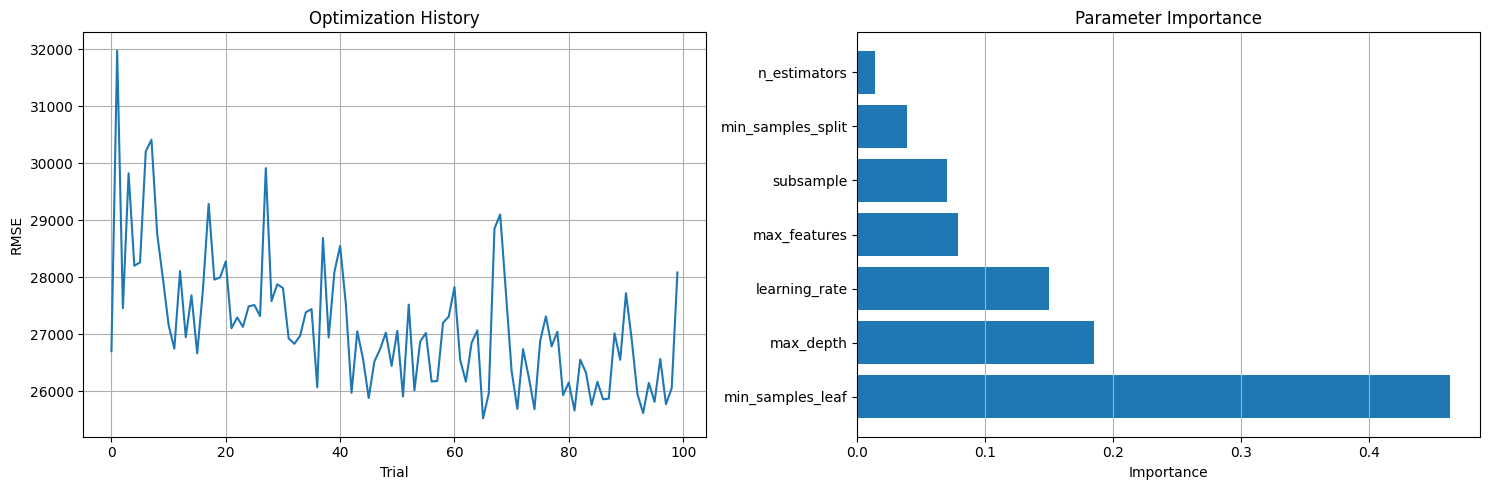


=== Training with Best Parameters ===
Optimized Gradient Boosting Performance:
Model Performance (CV): $25,266.99 (+/- $7,175.22)
Percentage Error (CV): 13.97% (+/- 3.97%)
Target variable mean: $180,921.20

=== Comparison with Baseline ===
Baseline Gradient Boosting Performance:
Model Performance (CV): $25,893.63 (+/- $6,970.47)
Percentage Error (CV): 14.31% (+/- 3.85%)
Target variable mean: $180,921.20

Improvement: 2.32% reduction in RMSE


In [135]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

def objective(trial):
    """
    Objective function for Optuna optimization
    """
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    
    # Create model with suggested parameters
    model = GradientBoostingRegressor(**params)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, final_df, y, cv=5, scoring='neg_mean_squared_error')
    
    # Return mean RMSE (Optuna minimizes by default)
    rmse = np.sqrt(-cv_scores.mean())
    return rmse

# Create study and optimize
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Print best parameters and score
print("\n=== Best Parameters ===")
print(study.best_params)
print(f"\nBest RMSE: ${study.best_value:,.2f}")

# Calculate percentage error for best model
mean_target = y.mean()
percentage_error = (study.best_value / mean_target) * 100
print(f"Best Percentage Error: {percentage_error:.2f}%")


# ==============================================================
# Visualize Optuna Study Results

# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot trial values
trials_df = study.trials_dataframe()
ax1.plot(trials_df['number'], trials_df['value'])
ax1.set_xlabel('Trial')
ax1.set_ylabel('RMSE')
ax1.set_title('Optimization History')
ax1.grid(True)

# Plot parameter importance
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    ax2.barh(params, values)
    ax2.set_xlabel('Importance')
    ax2.set_title('Parameter Importance')
    ax2.grid(True, axis='x')
except:
    ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
             ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()
plt.show()


# ==============================================================
# Train the best model

# Train model with best parameters
print("\n=== Training with Best Parameters ===")
best_params = study.best_params
best_params['random_state'] = 42

best_gb_model = GradientBoostingRegressor(**best_params)

# Cross-validate with best parameters
best_cv_scores = cross_val_score(best_gb_model, final_df, y, cv=5, scoring='neg_mean_squared_error')
print("Optimized Gradient Boosting Performance:")
print_scores(best_cv_scores)

# Compare with baseline
print("\n=== Comparison with Baseline ===")
baseline_gb = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
baseline_cv_scores = cross_val_score(baseline_gb, final_df, y, cv=5, scoring='neg_mean_squared_error')
print("Baseline Gradient Boosting Performance:")
print_scores(baseline_cv_scores)

# Calculate improvement
baseline_rmse = np.sqrt(-baseline_cv_scores.mean())
optimized_rmse = np.sqrt(-best_cv_scores.mean())
improvement = ((baseline_rmse - optimized_rmse) / baseline_rmse) * 100
print(f"\nImprovement: {improvement:.2f}% reduction in RMSE")

In [138]:
print("Best parameters:")
print(study.best_params)

Best parameters:
{'n_estimators': 221, 'learning_rate': 0.13275517953802823, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3, 'subsample': 0.7652505358562287, 'max_features': None}


In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

best_params = {'n_estimators': 221, 'learning_rate': 0.13275517953802823, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3, 'subsample': 0.7652505358562287, 'max_features': None}

# Train the model with the best parameters
model = GradientBoostingRegressor(**best_params)